In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import warnings


from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


import geopandas as gpd
from shapely.geometry import Point, Polygon

# At first we mount the dataset from local file

inputdf = pd.read_csv('Crime.csv')

In [ ]:


# sneak peak in the data
inputdf.head(2)


In [ ]:
print(inputdf.shape)
# 'column names are:' 
inputdf.columns
inputdf.dtypes

Analyzing the dataset, we observe that columns -


* Incident ID
*	Offence Code
* CR Number
* NIBRS Code
* State (All should be MD)
* Sector, Beat, PRA - meaningless
* Address Number (included in "Block Address")
* Street Prefix (lots of missing values)
* Street Suffix (lots of missing values)
* Police District Number (meaningless)
* Location (pair of Latitude and Longitude)

 are unnecessary. So they are removed.

In [ ]:
# dropping the unnecessary columns
#inputdf = data
unnecessary_columns = ['Incident ID', 'Offence Code', 'CR Number', 'NIBRS Code', 'State', 'Sector', 'Beat', 'PRA', 'Address Number', 'Street Prefix', 'Street Suffix', 'Police District Number', 'Location'  ]
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

# Later, Columns related with the effect of crime are removed.

In [ ]:
unnecessary_columns = ['Dispatch Date / Time', 'Victims', 'Block Address', 'Street Type', 'Agency', 'End_Date_Time']
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

Some columns are confusing to be added now. Such as -

* Crime Name3
* Zip Code
* Street Name
* Also we have to take special care of Latitude and Longitude if we want them to include in our feature set.

# Now we have to visualize the data and fix what to predict from these modified feature set

In [ ]:
# Montgomery County maintained roads
# https://data.imap.maryland.gov/datasets/maryland::montgomery-county-maintained-roads/explore?location=39.168559%2C-76.905435%2C9.35
# https://catalog.data.gov/dataset/tiger-line-shapefile-2018-county-montgomery-county-md-all-roads-county-based-shapefile
# crs = {'init':'EPSG:4326'}
montgomery_county_map = gpd.read_file('Zipcodes.shp')
print(montgomery_county_map.crs) 
montgomery_county_map.to_crs(epsg=4326).plot()

# Other sources for multiple data view
# https://montgomeryplanning.org/tools/gis-and-mapping/map-library/

# Drop rows from the dataframe based on certain condition applied on a column


In [ ]:
# Filter all rows for Latitude is greater than or equal to 35
inputdf = inputdf[inputdf['Latitude'] > 35.0]
# inputdf['Latitude'].hist()

In [ ]:
# Filter all rows for Longitude is less than or equal to -70
inputdf = inputdf[inputdf['Longitude'] < -70]
# inputdf['Longitude'].hist()

In [ ]:
# inputdf['Crime Name2'].value_counts()
# # Filter all rows for that has occurances less than 5
# inputdf = inputdf[inputdf.columns[inputdf['Crime Name2'].value_counts() > 5]]

In [ ]:
inputdf['Crime Name2'].value_counts()

# Export Pandas DataFrame to CSV


In [ ]:

# inputdf.to_csv('potential feature set revised.csv')


# ‘geo_df’ that is a copy of our original data frame but with the newly created ‘geometry’ column.


In [ ]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(inputdf['Longitude'], inputdf['Latitude'])]
geo_df = gpd.GeoDataFrame(inputdf, 
                          crs = crs, 
                          geometry = geometry)

geo_df.head()

In [ ]:
geo_df.plot()

# Visualizing the Crime Data

In [ ]:
fig, ax = plt.subplots(figsize = (20,20))
montgomery_county_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = geo_df['Crime Name1'], ax=ax, cmap = 'rainbow',
            legend = True, #legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title('Montgomery County Crime type data Heatmap')
# plt.savefig('Crime Heat Map for Location')

In [ ]:
#geo_df['Crime Name1'].hist()
geo_df['Crime Name2'].count()
geo_df['Crime Name2'].value_counts()
# geo_df.groupby('Crime Name2').count() # per group data count


#geo_df['Latitude'].hist()

# Separating Train and Test Set for Crime Prediction for Location

In [ ]:
print(inputdf['Crime Name1'].value_counts())

# Creating The Location Based Crime Data Frame

In [1029]:
# loc_crime_df = inputdf[['Latitude', 'Longitude', 'Crime Name1']]
loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Zip Code', 'Place', 'Street Name', 'Latitude', 'Longitude']]
dates = pd.to_datetime(inputdf['Start_Date_Time'])
  
# extract Hours from Timestamp 
# rs = dates.dt.hour
# print(rs)
loc_crime_df['dateHour'] = dates.dt.hour
loc_crime_df['day'] = dates.dt.day
loc_crime_df['month'] = dates.dt.month
loc_crime_df.head()
# print(loc_crime_df.shape)
# loc_crime_df.dtypes


,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
0,Crime Against Property,Robbery,WHEATON,SILVER SPRING,20902.0,Street - Bus Stop,GEORGIA,39.036270,-77.049900,21,21,12
1,Crime Against Society,All Other Offenses,GERMANTOWN,DAMASCUS,20872.0,Parking Lot - Residential,COLTRANE,39.277840,-77.211500,17,8,8
2,Crime Against Society,Driving Under the Influence,ROCKVILLE,ROCKVILLE,20850.0,Street - In vehicle,GRANDIN,39.086688,-77.144754,2,3,1
3,Other,All Other Offenses,ROCKVILLE,ROCKVILLE,20850.0,Street - Other,GRANDIN,39.086688,-77.144754,2,3,1
4,Crime Against Property,Shoplifting,GERMANTOWN,GERMANTOWN,20876.0,Retail - Department/Discount Store,FREDERICK,39.198295,-77.244900,17,16,7


In [1030]:
 # Removing Rows on Count condition
counts = loc_crime_df['Crime Name2'].value_counts()
# print(counts)
threshold = 100
loc_crime_df = loc_crime_df.loc[loc_crime_df['Crime Name2'].isin(counts.index[counts >= threshold ])]



In [1031]:
 # Removing Rows on Count condition 
 # Pruning garbage data
# loc_crime_df = loc_crime_df[~loc_crime_df['Crime Name2'] == "All Other Offenses"]
indexAge = loc_crime_df[ loc_crime_df['Crime Name2'] == "All Other Offenses" ].index
loc_crime_df.drop(indexAge , inplace=True)
loc_crime_df.head()
counts = loc_crime_df['Crime Name2'].value_counts()
# print(counts)


# Taking only Top n classes in a column


In [1032]:
target_column = 'Crime Name2'
top_n = 7
top_classes = {}
top_classes = loc_crime_df[target_column].value_counts().nlargest(top_n).to_dict()
print(top_classes)
str_array = []
temp_df = pd.DataFrame()
for x in top_classes.keys():
    str_array.append(x)
    rows = loc_crime_df[loc_crime_df[target_column] == str (x) ]
    # print(rows)
    temp_df = temp_df.append(rows)
# print(str_array)
# temp_df

{'Theft From Motor Vehicle': 26252, 'Drug/Narcotic Violations': 22573, 'Simple Assault': 21064, 'Destruction/Damage/Vandalism of Property': 18967, 'Shoplifting': 16416, 'All other Larceny': 13972, 'Driving Under the Influence': 13723}


In [1033]:
# print(temp_df[target_column].value_counts())
loc_crime_df = temp_df
print(loc_crime_df[target_column].value_counts())

Theft From Motor Vehicle                    26252
Drug/Narcotic Violations                    22573
Simple Assault                              21064
Destruction/Damage/Vandalism of Property    18967
Shoplifting                                 16416
All other Larceny                           13972
Driving Under the Influence                 13723
Name: Crime Name2, dtype: int64


# Dropping null values in Zip code

In [1034]:
loc_crime_df['Zip Code'].value_counts()
# loc_crime_df['dateHour'].value_counts()

20910.0    11588
20902.0    10222
20874.0     8342
20906.0     8286
20904.0     8225
           ...  
28770.0        1
2088.0         1
20827.0        1
20881.0        1
2902.0         1
Name: Zip Code, Length: 115, dtype: int64

In [1035]:
loc_crime_df = loc_crime_df.dropna(axis=0, subset=['Zip Code'])
print(loc_crime_df.shape)

(131492, 12)


In [1036]:
# loc_crime_df['Crime Name2'].count()
# loc_crime_df['Crime Name2'].value_counts()

# Transform the data by label encoding

In [1037]:
encoded_dict ={}
temp_df_2 = pd.DataFrame()

def label_encoder(y):
    le = LabelEncoder()
    if str(y) == target_column:
        print(loc_crime_df[y])
    loc_crime_df[y] = le.fit_transform(loc_crime_df[y])
    if str(y) == target_column:
        print(loc_crime_df[y])
    if str(y) == target_column:
        temp_df_2[y] = le.inverse_transform(loc_crime_df[y])
        # encoded_dict = {loc_crime_df[y], temp_df_2[y]} 
    #print(temp_df[y])

#loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']]

label_list = ['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']
#label_list = ['Crime Name1']

for l in label_list:
    label_encoder(l)

# print(encoded_dict)
 
#Display transformed data
loc_crime_df.head()

20           Theft From Motor Vehicle
31           Theft From Motor Vehicle
61           Theft From Motor Vehicle
98           Theft From Motor Vehicle
116          Theft From Motor Vehicle
                     ...             
312057    Driving Under the Influence
312071    Driving Under the Influence
312117    Driving Under the Influence
312177    Driving Under the Influence
312229    Driving Under the Influence
Name: Crime Name2, Length: 131492, dtype: object
20        6
31        6
61        6
98        6
116       6
         ..
312057    2
312071    2
312117    2
312177    2
312229    2
Name: Crime Name2, Length: 131492, dtype: int32


,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
20,1,6,6,33,20904.0,43,759,39.08299,-76.9481,11,7,11
31,1,6,5,31,20852.0,43,3106,39.05840,-77.1263,20,27,1
61,1,6,6,33,20904.0,43,4708,39.06081,-76.9634,10,17,9
98,1,6,0,11,20815.0,59,2427,39.00547,-77.0720,20,28,12
116,1,6,2,18,20874.0,49,5689,39.15549,-77.2763,18,26,12


In [1038]:
# print(loc_crime_df['Crime Name1'].value_counts())
# print(temp_df['Crime Name1'].value_counts())

In [1039]:
#Divide the dataset into independent and dependent variables
# X = loc_crime_df.drop([target_column],axis=1)
# y = loc_crime_df[target_column]

# Going for specigic prediction without geolocation
X = loc_crime_df.drop([target_column, 'Latitude', 'Longitude'],axis=1)
y = loc_crime_df[target_column]


# Going for generic prediction
# X = loc_crime_df.drop([target_column,'Crime Name2', 'Latitude', 'Longitude'],axis=1)
# y = loc_crime_df[target_column]

print(X)


        Crime Name1  Police District Name  City  Zip Code  Place  Street Name  \
20                1                     6    33   20904.0     43          759   
31                1                     5    31   20852.0     43         3106   
61                1                     6    33   20904.0     43         4708   
98                1                     0    11   20815.0     59         2427   
116               1                     2    18   20874.0     49         5689   
...             ...                   ...   ...       ...    ...          ...   
312057            2                     2    18   20874.0     89         5068   
312071            2                     6    35   20912.0     89         2328   
312117            2                     0    31   20852.0     89         4786   
312177            2                     3    16   20877.0     88         2265   
312229            2                     2    16   20882.0     89         6453   

        dateHour  day  mont

In [1040]:
print(y.value_counts())

6    25821
3    22237
5    20985
1    18776
4    16345
0    13819
2    13509
Name: Crime Name2, dtype: int64


In [1041]:
#Split the data into training and testing set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=42, shuffle = True) 

#Data was splitted as 80% train data and 20% test data.

# y_train = y_train.values.reshape(-1,1)
# y_test = y_test.values.reshape(-1,1)

print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train shape: (105193, 9)
X_test shape: (26299, 9)
y_train shape: (105193,)
y_test shape: (26299,)


In [1042]:
#Feature Scaling (Standardize the data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# We will build all six models and compare their accuracy scores.



In [1043]:
#To store results of models, we create two dictionaries
result_dict_train = {}
result_dict_test = {}

# Machine Leaning Models and their performance


In [1044]:
models = {'Naïve Bayes Classifier': GaussianNB, 'Decision Tree Classifier' : DecisionTreeClassifier, 'KNN Classifier': KNeighborsClassifier,
        'Random Forest Classifier': RandomForestClassifier,'Logistic Regression': LogisticRegression}
        # , 'Support Vector Classifier': SVC}
# for keys, values in sorted(models.items()):
#     print(keys +" is "+ values)

warnings.filterwarnings("ignore")

# for name, model in models.items():
#     print(name +" is "+ model)
    

Naïve Bayes Classifier is running
Train Score: 0.5184756397045345
Test Score: 0.5150766188828473
Test Score (F1 - micro): 0.5150766188828473
Test Score (F1 - macro): 0.43293065770092365
Test Score (F1 - weighted): 0.4559727181674177


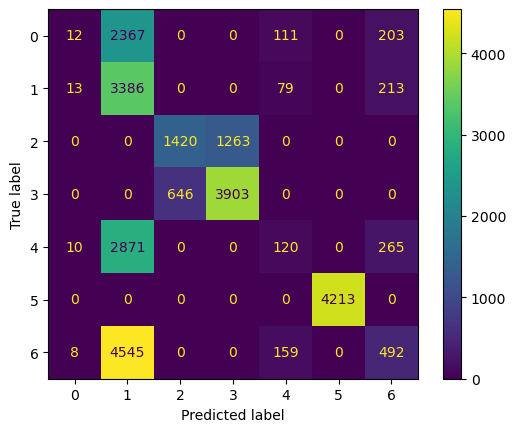

Decision Tree Classifier is running
Train Score: 0.6717651835424261
Test Score: 0.6716605194113845
Test Score (F1 - micro): 0.6716605194113845
Test Score (F1 - macro): 0.6591180619121209
Test Score (F1 - weighted): 0.6739418257994388


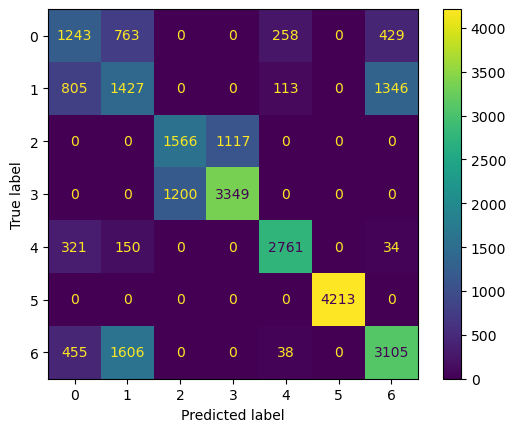

KNN Classifier is running
Train Score: 0.6470487389182271
Test Score: 0.6494543518764972
Test Score (F1 - micro): 0.6494543518764972
Test Score (F1 - macro): 0.6267607974873766
Test Score (F1 - weighted): 0.6454977629971745


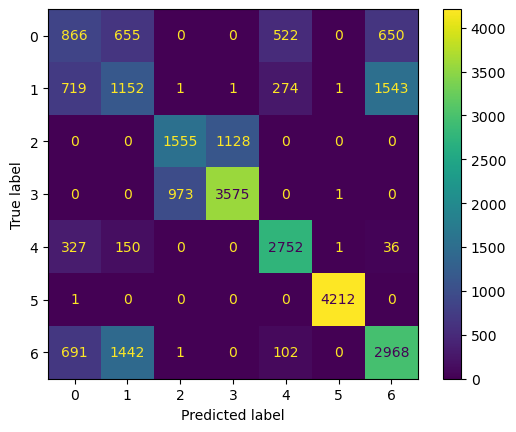

Random Forest Classifier is running
Train Score: 0.7349633303382934
Test Score: 0.7360736149663485
Test Score (F1 - micro): 0.7360736149663485
Test Score (F1 - macro): 0.7117875754574514
Test Score (F1 - weighted): 0.7274695987782098


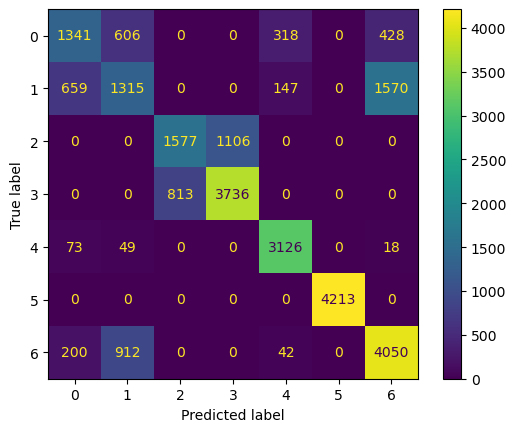

Logistic Regression is running
Train Score: 0.5532973017606617
Test Score: 0.5575116924597894
Test Score (F1 - micro): 0.5575116924597894
Test Score (F1 - macro): 0.4594993386190217
Test Score (F1 - weighted): 0.49773117928074634


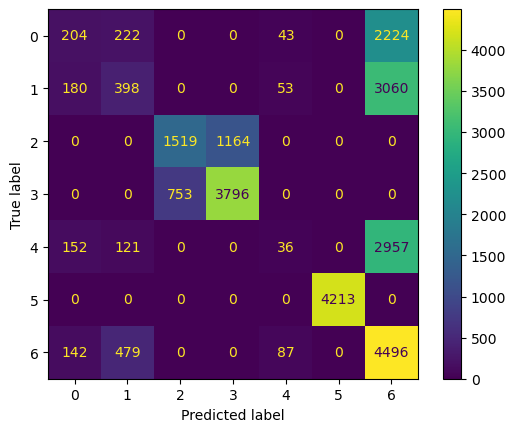

In [1045]:
for model_name, model_function in models.items():
    print(model_name +' is running')
    try:
        model = model_function(random_state = 42)
    except:
        if(model_name=='Logistic Regression'):
            model = model_function(solver='lbfgs', max_iter=1000)
        model = model_function()
    accuracies = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    #Obtain accuracy
    print("Train Score:",np.mean(accuracies))
    print("Test Score:",model.score(X_test,y_test))
    print("Test Score (F1 - micro):",f1_score(y_test, y_pred, average='micro'))
    print("Test Score (F1 - macro):",f1_score(y_test, y_pred, average='macro'))
    print("Test Score (F1 - weighted):",f1_score(y_test, y_pred, average='weighted'))

    #Confusion matrix
    plot_confusion_matrix(model, X_test, y_test)  
    plt.show()


    #Store results in the dictionaries
    result_dict_train['Train Score for '+model_name] = np.mean(accuracies)
    result_dict_test['Test Score for '+model_name] = model.score(X_test,y_test)
    


In [1046]:
# lengthy_models = {'Support Vector Classifier': SVC,
#         'Random Forest Classifier': RandomForestClassifier}
# for model_name, model_function in lengthy_models.items():
#     print(model_name +' is running')
#     try:
#         model = model_function(random_state = 42)
#     except:
#         model = model_function()
#     accuracies = cross_val_score(model, X_train, y_train, cv=5)
#     model.fit(X_train,y_train)
#     y_pred = model.predict(X_test)

#     #Obtain accuracy
#     print("Train Score:",np.mean(accuracies))
#     print("Test Score:",model.score(X_test,y_test))


#     # #Store results in the dictionaries
#     # result_dict_train['Train Score for '+model_name] = np.mean(accuracies)
#     # result_dict_test['Test Score for '+model_name] = model.score(X_test,y_test)

# Compare Accuracy Scores

In [1047]:
df_result_train = pd.DataFrame.from_dict(result_dict_train,orient = "index", columns=["Score"])
print(df_result_train)

df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index",columns=["Score"])
df_result_test


                                             Score
Train Score for Naïve Bayes Classifier    0.518476
Train Score for Decision Tree Classifier  0.671765
Train Score for KNN Classifier            0.647049
Train Score for Random Forest Classifier  0.734963
Train Score for Logistic Regression       0.553297


,Score
Test Score for Naïve Bayes Classifier,0.515077
Test Score for Decision Tree Classifier,0.671661
Test Score for KNN Classifier,0.649454
Test Score for Random Forest Classifier,0.736074
Test Score for Logistic Regression,0.557512


# Display the accuracy scores

[Text(0, 0, 'Test Score for Naïve Bayes Classifier'),
 Text(1, 0, 'Test Score for Decision Tree Classifier'),
 Text(2, 0, 'Test Score for KNN Classifier'),
 Text(3, 0, 'Test Score for Random Forest Classifier'),
 Text(4, 0, 'Test Score for Logistic Regression')]

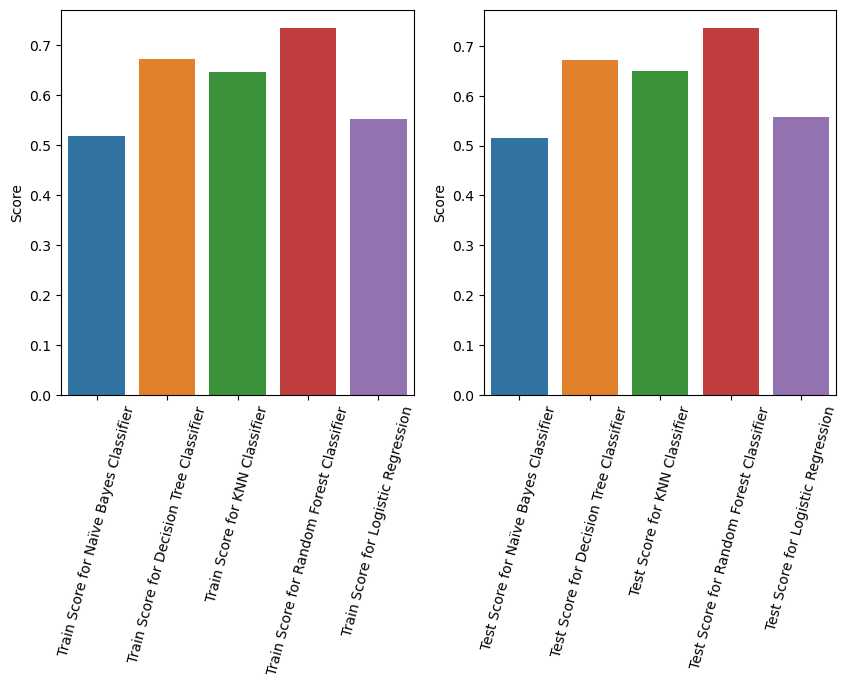

In [1048]:
import seaborn as sns

fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x = df_result_train.index,y = df_result_train.Score,ax = ax[0])
sns.barplot(x = df_result_test.index,y = df_result_test.Score,ax = ax[1])
ax[0].set_xticklabels(df_result_train.index,rotation = 75)
ax[1].set_xticklabels(df_result_test.index,rotation = 75)
#plt.show()
# plt.savefig('Predicting Specific Crime With Location')